(리더보드의 점수 0.835는 하이퍼파라미터에서 dropout=0.5, epoch=500 번 정도에 해당하는 점수입니다.)

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import IPython.display as ipd

In [3]:
import time

In [4]:
batch_size = 1024
epochs = 500

validation = False
if validation:
    val_size = .25
    early_stopping = 50
    seed = 0
else:
    val_size = .0
    early_stopping = 0
    seed = None
    
LR = 1e-4

In [5]:
crop = True
rotation = True
perspective = True
normalization = True

In [6]:
concat = True

In [7]:
dropout = .25

In [8]:
train = pd.read_csv('handwriting_dataset/train/train_data.csv')
test = pd.read_csv('handwriting_dataset/test/test_data.csv')

In [9]:
images = []

for image_name in train['file_name']:
    image = np.array(Image.open(f'handwriting_dataset/train/{image_name}'))
    images.append(image)
    
X = np.expand_dims(np.array(images), -1)
if concat:
    X = np.concatenate([X, X, X], -1)
y = np.array(train['label'])

test_images = []
for image_name in test['file_name']:
    image = np.array(Image.open(f'handwriting_dataset/test/{image_name}'))
    test_images.append(image)
    
X_test = np.expand_dims(np.array(test_images), -1)
if concat:
    X_test = np.concatenate([X_test, X_test, X_test], -1)
    
print(X.shape, y.shape, X_test.shape)

(5000, 28, 28, 3) (5000,) (5000, 28, 28, 3)


In [10]:
if validation:
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=val_size, random_state=seed)
else:
    X_train, y_train = X, y

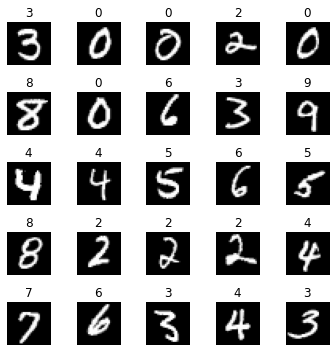

In [11]:
nrows, ncols = 5,5

indices = np.random.randint(len(X), size=(nrows, ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5,5))
for i in range(nrows):
    for j in range(ncols):
        idx = indices[i][j]
        ax[i][j].imshow(X[idx], cmap='gray')
        ax[i][j].set_title(f"{y[idx]}")
        ax[i][j].axis('off')
        
plt.tight_layout()
plt.show()

In [12]:
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models

In [13]:
def get_transform(train=True):
    t = list()
    t.append(transforms.ToTensor())
    if crop and train:
        t.append(transforms.RandomResizedCrop(size=28, scale=(.35,1.), ratio=(.5,2), interpolation=transforms.InterpolationMode.NEAREST))
    if rotation and train:
        t.append(transforms.RandomRotation(
        degrees=25, interpolation=transforms.InterpolationMode.NEAREST))
    if normalization:
        t.append(transforms.Normalize(mean=(.5), std=(.5)))
    return transforms.Compose(t)

In [14]:
class CustomDataset(Dataset):
    def __init__(self, X, y=None, transform=None, target_transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        inputs = self.X[idx]
        if transform:
            inputs = self.transform(inputs)
        if self.y is not None:
            labels = self.y[idx]
            if self.target_transform:
                labels = self.target_transform(labels)
            return inputs, labels
        return inputs

In [15]:
transform = get_transform()
transform_test = get_transform(train=False)

In [16]:
transformed_train = CustomDataset(X=X_train, y=y_train, transform=transform)
if validation:
    transformed_valid = CustomDataset(X=X_valid, y=y_valid, transform=transform_test)
transformed_test = CustomDataset(X=X_test, transform=transform_test)

In [17]:
trainloader = DataLoader(transformed_train, batch_size=batch_size, shuffle=True)
if validation:
    validloader = DataLoader(transformed_valid, batch_size=batch_size, shuffle=False)
testloader = DataLoader(transformed_test, batch_size=batch_size, shuffle=False)

In [18]:
def get_transform(train=True):
    t = list()
    t.append(transforms.ToTensor())
    if crop and train:
        t.append(transforms.RandomResizedCrop(size=28,scale=(.65, 1.),ratio=(.75,1+1/3),interpolation=transforms.InterpolationMode.NEAREST))
    if rotation and train:
        t.append(transforms.RandomRotation(
            degrees=25,interpolation=transforms.InterpolationMode.NEAREST))
    if perspective and train:
        t.append(transforms.RandomPerspective(distortion_scale=.55,p=.75,interpolation=transforms.InterpolationMode.NEAREST))
    if normalization:
        t.append(transforms.Normalize(mean=(.5),std=(.5)))
    return transforms.Compose(t)

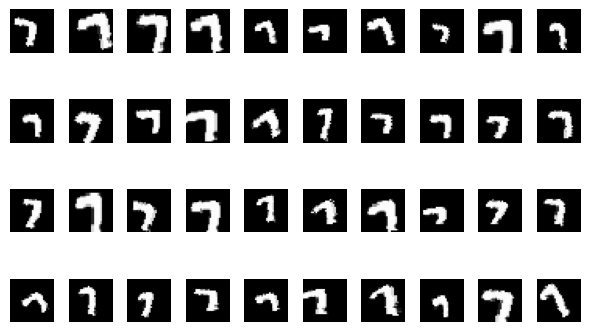

In [23]:
animation = False
transform = get_transform()
idx = np.random.randint(len(X))
if animation:
    for _ in range(100):
        ipd.clear_output(wait=True)
        fig, ax = plt.subplots(ncols=2)
        ax[0].imshow(np.squeeze(X[idx]), cmap='gray')
        ax[1].imshow(np.squeeze(transform(X[idx]))[0], cmap='gray')
        ax[0].axis('off')
        ax[1].axis('off')
        plt.show()
else:
    fig, ax = plt.subplots(nrows=4, ncols=10,dpi=100)
    for i in range(4):
        for j in range(10):
            ax[i][j].imshow(np.squeeze(transform(X[idx]))[0], cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout()
    plt.show()

In [24]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        if concat:
            pass
        else:
            self.inputs = nn.Conv2d(1, 3, kernel_size=(1,1))
        self.model = models.resnet18(pretrained=False)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(1000,10)
    def forward(self, x, softmax=True):
        if concat:
            pass
        else:
            x = self.inputs(x)
        x = self.model(x)
        x = self.drop(x)
        x = self.fc(x)
        if softmax:
            x = F.softmax(x)
        return x

In [26]:
model = Model()
model.train()
'DONE'

'DONE'

In [27]:
min_valid_loss = 1e100
patience = 0

In [28]:
optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [31]:
model_filename = f"./weights/model-BS{batch_size}-E{epochs}-V{str(validation)[0]}-VS{val_size:.2f}-SD{seed}-LR{LR}-es{early_stopping}"

In [35]:
for e in range(epochs):
    start_time = time.time()
    learning_loss = list()
    train_acc = list()
    for i,d in enumerate(trainloader, 0):
        inputs, labels = d
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        learning_loss.append(loss.item())
        train_acc.append(
        torch.sum(
        torch.argmax(outputs, -1) == labels)
        .item()/len(outputs))
    learning_loss = np.mean(learning_loss)
    train_acc = np.mean(train_acc)
    
    if validation:
        
        val_loss = list()
        val_acc = list()
        with torch.no_grad():
            for i,d in enumerate(validloader, 0):
                inputs, labels = d
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss.append(loss.item())
                val_acc.append(torch.sum(torch.argmax(outputs, -1) == labels).items()/len(outputs))
        val_loss = np.mean(val_loss)
        val_acc = np.mean(val_acc)
        if val_loss < min_valid_loss:
            min_valid_loss = val_loss
            patience = 0
            torch.save(model.state_dict(), model_filename)
        else:
            patience += 1
        if patience == early_stopping:
            break
    ipd.clear_output(wait=True)
    print(f"{e+1}/{epochs}")
    print(f"current train loss={learning_loss:.4f}, acc={train_acc*100:.2f}%")
    if validation:
        print(f"current val loss={val_loss:.4f}, acc={val_acc*100:.2f}%")
        print(f"patience={patience}")
        print(f"min val loss={min_valid_loss:.4f}")
    print(f"{time.time()-start_time:.2f} sec/epoch")
    
if validation:
    model.load_state_dict(torch.load(model_filename))
    model.eval()
    
    val_loss = list()
    val_acc = list()
    with torch.no_grad():
        for i, d in enumerate(validloader, 0):
            inputs, labels = d
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())
            val_acc.append(torch.sum(torch.argmax(outputs,-1)==labels).item()/len(outputs))
    val_loss = np.mean(val_loss)
    val_acc = np.mean(val_acc)
    print(val_acc)
    
print('DONE')

221/500
current train loss=1.5372, acc=92.45%
60.53 sec/epoch


KeyboardInterrupt: 

In [ ]:
y_pred = list()
with torch.no_grad():
    for i, d in enumerate(testloader, 0):
        inputs = d.cuda()
        outputs = model(inputs)
        y_pred.append(torch.argmax(outputs, -1).cpu().numpy())
y_pred = np.concatenate(y_pred, 0)

In [ ]:
nrows, ncols = 5, 10

indices = np.random.randint(len(X), size=(nrows, ncols))

indices = np.random.randint(len(X), size=(nrows, ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, dpi=100, figsize=(5,5))
for i in range(nrows):
    for j in range(ncols):
        idx = indices[i][j]
        ax[i][j].imshow(X_test[idx], cmap='gray')
        ax[i][j].set_title(f"{y_pred[idx]}")
        ax[i][j].axis("off")
plt.tight_layout()
plt.show()